# Generating new places in County Durham with bigrams

Consider the problem of generating text that is in some sense _resembles_ some fixed dataset. For our example we take place names in County Durham and hence our task is to create new place names that are believable. 

A fundamental difficulty in language modeling is the _curse of dimensionality_. When evaluating any model, data in the test set is unlikely to be seen in the training phase. As a first step towards our text generation problem, we construct a simple _bigram_ model that will serve as a baseline from which later models will be compared to. The premise of the bigram model is simple. A name is generated one character at a time and each character is generated with probability proportional to the frequency it followed the previous letter in the training set.

The code used in this notebook draws heavily from the excellent [Andrej Karpathy video](https://www.youtube.com/watch?v=PaCmpygFfXo) on bigrams.

<font color='0789DF'>Table of contents<font><a class='anchor' id='top'></a>
- [Reading in the data](#readingdata)
- [Introduction to $n$-grams](#introngrams)
- [Constructing the bigram dictionary](#bigramdict)
- [Visualising the frequency of bigrams](#visual)
- [Sampling from the bigram model](#sampling)
- [Evaluating the bigram model](#eval)

## Reading in the data <a class="anchor" id="readingdata">

Our first step is to read in the data. In the file `place_names_durham` there are a collection of named locations in County Durham.

In [17]:
places = open('place_names_durham.txt', 'r').read().splitlines()

Looking at the first few entries, we see a sample of the names we will train our model on. The entries being in lower case is not an issue as how the place names are actually capitalised does not introduce ambiguities. At the final step where we generate new place names, we can capitalise the output.

In [18]:
places[:5]

['addison', 'adelaide bank', 'aislaby', 'albany', 'albert hill']

We also see that in total we have 1182 unique place names.

In [19]:
len(places)

1182

## Introduction to $n$-grams <a class="anchor" id="introngrams">

The idea of $n$-grams is to construct a probability distribution over sequences of characters seen in `places` where the $n$-th character is chosen given the previous $n-1$ characters with probability proportional to the frequency that those $n$ characters occur in that sequence in `places`.

Suppose we wish to sample a sequence of characters $x_1, x_2, \ldots, x_{100}$ with $n$-grams where $n<100$. The probability distribution for generating $x_1, x_2, \ldots, x_{100}$ is given by

$$
    \mathbb{P}(x_1,x_2,\ldots,x_{100}) = \mathbb{P}(x_1,x_2,\ldots,x_{n-1})\prod_{t=n}^{100}\mathbb{P}(x_t|x_{t-n+1},\ldots,x_{t-1}).
$$

The case $n=2$ is called _bigrams_. For bigrams, the next character is chosen with probability proportional to the frequency it followed the previous character in `places`. Next we will use bigrams to generate new place names in County Durham.

## Constructing the bigram dictionary <a class="anchor" id="bigramdict">

Our goal will be to generate new names one character at a time by estimating the probability of what character is most likely to be next. To understand how the bigram model will do this, first we view each entry in `places` as an ordered collection of characters.

In [20]:
p = places[0]
print(p)
list(p)

addison


['a', 'd', 'd', 'i', 's', 'o', 'n']

In the variable `chars` we store each character used in `places`. Note that `chars` contains spaces, dashes, and apostrophes.

In [21]:
chars = sorted(list(set(''.join(places))))
print(chars)

[' ', "'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


We construct a matrix `N` (as a `torch` tensor) that will store the frequency that bigrams appear in `places`. 

`stoi` is a dictionary that maps characters to integers.

We add a fullstop to our dictionary as we will use a fullstop to indicate the beginning or end of a place name. Our model must learn when to end a place name too!

In [22]:
import torch

N = torch.zeros((len(chars)+1, len(chars)+1), dtype=torch.int32)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
stoi

{' ': 1,
 "'": 2,
 '-': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29,
 '.': 0}

Now we create our bigram dictionary. For each entry in `places` we deconstruct the entry into its ordered characters with a fullstop at the beginning and end. We loop over the entry in a sliding window to count which bigrams appear and store the counts in `N`.

In [23]:
for w in places:
    chs = ['.'] + list(w) + ['.'] # append start and end characters 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

It will also be useful to map from integers to characters. For this purpose we introduce `itos` that is a dictionary from integers to characters that complements `stoi`.

In [24]:
itos = {i:s for s,i in stoi.items()}
itos

{1: ' ',
 2: "'",
 3: '-',
 4: 'a',
 5: 'b',
 6: 'c',
 7: 'd',
 8: 'e',
 9: 'f',
 10: 'g',
 11: 'h',
 12: 'i',
 13: 'j',
 14: 'k',
 15: 'l',
 16: 'm',
 17: 'n',
 18: 'o',
 19: 'p',
 20: 'q',
 21: 'r',
 22: 's',
 23: 't',
 24: 'u',
 25: 'v',
 26: 'w',
 27: 'x',
 28: 'y',
 29: 'z',
 0: '.'}

## Visualising the frequency of bigrams <a class="anchor" id="visual">

To aid in our understanding of how the bigram model works we can visualise the frequency of bigrams in `N` with the following code.

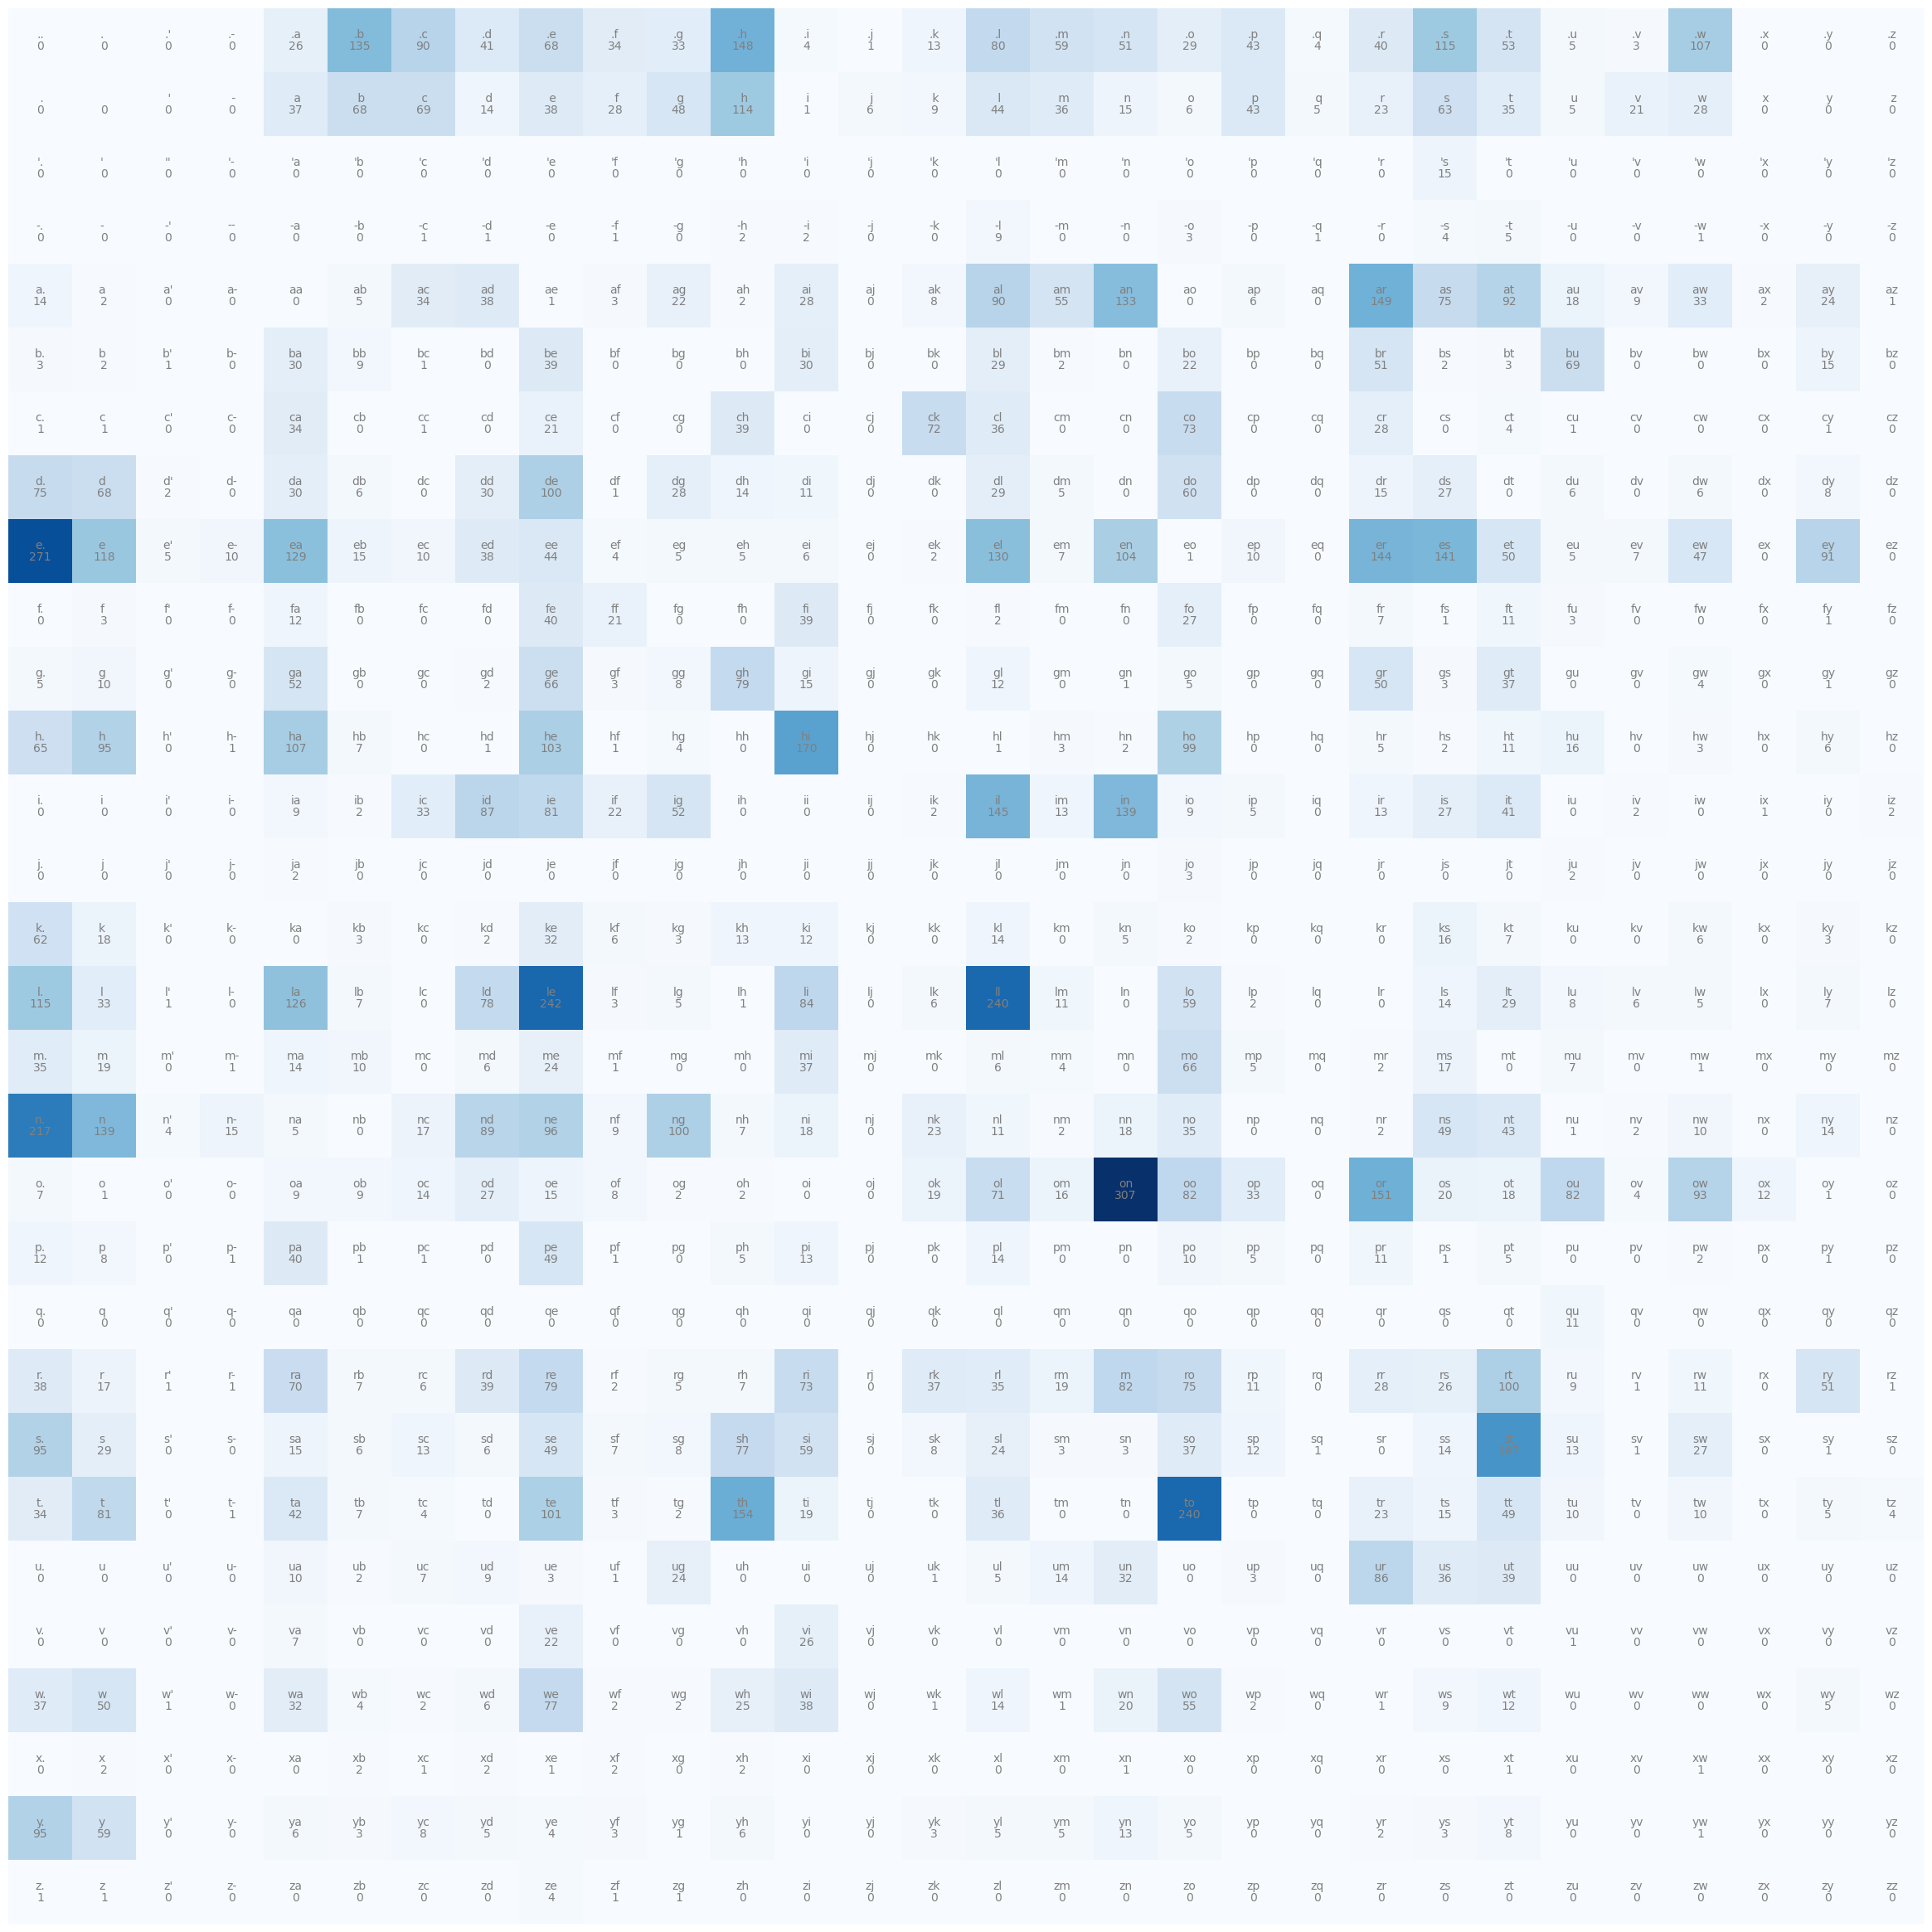

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30, 30))
plt.imshow(N, cmap='Blues')
for i in range(len(chars)+1):
    for j in range(len(chars)+1):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

To understand how to generate new place names, consider the first row of `N` that can be read with `N[0]`.

In [26]:
N[0]

tensor([  0,   0,   0,   0,  26, 135,  90,  41,  68,  34,  33, 148,   4,   1,
         13,  80,  59,  51,  29,  43,   4,  40, 115,  53,   5,   3, 107,   0,
          0,   0], dtype=torch.int32)

The entries in `N[0]` give the frequency of each character being the first letter of a place name. A simple way to generate the first letter of a new place name is to use these frequencies to create a vector containing probabilities of which letter should come first.

In [27]:
p = N[0].float() # convert to float for normalisation
p /= p.sum()
p

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0220, 0.1142, 0.0761, 0.0347, 0.0575,
        0.0288, 0.0279, 0.1252, 0.0034, 0.0008, 0.0110, 0.0677, 0.0499, 0.0431,
        0.0245, 0.0364, 0.0034, 0.0338, 0.0973, 0.0448, 0.0042, 0.0025, 0.0905,
        0.0000, 0.0000, 0.0000])

The output `p` is a vector of probabilities for each character coming first in a new place names. We can sample this using `torch.multinomial` and then translating from integers to characters using `itos`.

In [28]:
g = torch.Generator().manual_seed(1241243)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

'b'

We see that we sample `b` and this will be the first letter of a new place name.

__Are we overfitting?__. A good machine learning model _generalises_ beyond the observed training data. One issue in the bigram model is that most bigrams will have a count of zero. This is a problem as the model is too confident that certain bigrams will never occur when in reality they are perfectly plausible.

__Smoothing__. To ward against the issue of zero counts we will augment `N` by adding a small constant to each entry. We _smooth_ our model to ensure we will never be dividing by zero by adding a small number to each entry in `N`.

In [29]:
P = (N+1e-1).float()
P /= P.sum(1, keepdim=True)

## Sampling from the bigram model <a class="anchor" id="sampling">

To see the bigram model in action, let's generate new place names with the probabilities given by normalising the rows in `N` with smoothing.

In [30]:
g = torch.Generator().manual_seed(2524542)

for i in range(5):
    
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    generated_string = ''.join(out).title()  # Capitalize the generated string
    
    
    print(generated_string)

Batharessh.
Tarkey Chrdoe.
W.
Pigas.
Misperillg Bbuge E.


While some place names are close to believable, many are not. Some are just a single character! Clearly we need to improve upon the bigram model to generate better place names. 

## Evaluating the bigram model <a class="anchor" id="eval">

In order to judge whether another model is improving on the bigram model, we need to measure performance.
    
__How likely is it our model produces a known place?__ Consider how probable it is that our model produces the word `Durham`. That is, we want to calculate 
    
$$
    P(\text{Durham}) := \mathbb{P}(x_1=\text{d}, x_2=\text{u}, x_3=\text{r}, x_4=\text{h}, x_5=\text{a}, x_6=\text{m}, x_7=\text{.})
$$
    
Breaking this down with conditional probabilities, we have that $P($Durham$)$ is equal to
    
$$
    \mathbb{P}(x_1=\text{d})\mathbb{P}(x_2=\text{u}|x_1=d)\mathbb{P}(x_2=\text{r}|x_1=u)\mathbb{P}(x_2=\text{r}|x_1=r)\mathbb{P}(x_2=\text{h}|x_1=r)\mathbb{P}(x_2=\text{a}|x_1=h)\mathbb{P}(x_2=\text{m}|x_1=a)\mathbb{P}(x_2=\text{.}|x_1=m).
$$
    
Note that the distribution of the next character only depends on the previous character, not the position it occurs, which allows us to simplify the expression by rewriting the probabilities in terms of the first and second character.
    
__Negative log-likelihood__. Working with sums of probabilities is easier than products and so we take the logarithm and observe that
    
$$
    \log(P(\text{durham})) = \log(\mathbb{P}(x_1=\text{d})) + \log(\mathbb{P}(x_2=\text{u}|x_1=d)) + \cdots + \log(\mathbb{P}(x_2=\text{.}|x_1=m)).
$$

Taking the convention that our loss should be _minimised_ we take the negative log-likelihood, which is 
    
$$
    \text{NLL}(\text{Durham}) = -\log(P(\text{durham})).
$$ 
    
NLL(Durham) can be easily computed by looking up the corresponding probabilities from `N` that are stored in `P`. The number NLL(Durham) is the score that tells us how likely it is we observed Durham from our model. 
    
Now, to evaluate our model, we calculate the negative log-likelihood for each place name in `places` and calculate the average value.

In [31]:
log_likelihood = 0.0
n = 0
for w in places:
    chs = ['.'] + list(w) + ['.']  
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-34717.1602)
nll=tensor(34717.1602)
2.4294724464416504


The final number of `2.4267501831054688` is the average negative log-likelihood per entry in our training set. 

Now that we have a benchmark model, our aim is to improve upon it and this is achieved in later notebooks with neural networks.